Este colab fue desarrollado por Arnold Charry Armero.

# Capacitated Vehicle Routing Problem (CVRP)

El VRP (Vehicle Routing Problem) consiste en la programación de vehículos en rutas entregando el producto a los clientes respetando su máxima capacidad. En este colab de Python se muestra un ejemplo de VRP con máxima capacidad para 10 clientes y el depot (punto de origen), ilustrando como funciona un algoritmo de optimización exacto para estas situaciones.

## Conjuntos

$ i = \text{nodo }i$

$ j = \text{nodo }j$

$ k = \text{vehículo }k$

## Parámetros

$ d_{ij} = \text{Distancia del nodo }i \text{ al nodo } j$

$ q_{j} = \text{Demanda en el nodo }i $

$ Q = \text{Capacidad total en el camión }$

$ n = \text{Número de puntos o ciudades a visitar} $

## Variables de decisión

$ x_{ijk} = \text{1 si se va del nodo } i \text{ al nodo } j  \text{ en el vehículo }k, \text{0 lo contrario}$

$ u_{i} = \text{variable de eliminación de subtour } i $

$ u_{j} = \text{variable de eliminación de subtour } j $

## Función Objetivo

$\text{ f.o. } $

$$ \text{min} \: z = \sum_{i=1}^{} \sum_{j=1}^{} \sum_{k=1}^{} d_{ij} \:x_{ijk} $$

## Restricciones

$\text{ s.a. } $

No puede haber un viaje hacia sí mismo,

$$ x_{ijk} = 0, \forall i = j \:\:\forall k $$

El vehículo deja un nodo para entrar a otro,

$$ \sum_{i=1}^{} x_{ijk} = \sum_{i=1}^{} x_{jik},\: \forall j  \: \:\forall k $$

En el nodo se ingresa una sola vez,

$$ \sum_{i=1}^{} \sum_{k=1}^{} x_{ijk} = 1, \: \forall j \in \left \{ 2,\cdots , n \right \}$$

Todos los vehiculos parten del mismo punto de origen,
$$ \sum_{j=2}^{} x_{1jk}= 1, \: \forall k $$

No se puede rebasar la capacidad del camión,

$$ \sum_{i=1}^{} \sum_{j=2}^{} q_{j}\: x_{ijk} \leq Q, \:\: \forall k$$


Eliminación de los subtours,

$$ u_{j} - u_{i} \geq  q_{j} - Q (1-x_{ijk}), \: \forall i \neq  j \:\: \forall k$$

$$ q_{i} \leq u_{i} \leq Q, \: \forall i $$

In [1]:
# Se define la función para calcular distancias
def distance_points(x1, y1, x2, y2):
  import numpy as np
  distance = round(np.sqrt((x1 - x2)**2 + (y1 - y2)**2))
  return distance

In [2]:
#Conectamos con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Se instala la libreria para leer archivos de Excel
!pip install openpyxl

In [4]:
#Se instala la libreria
!pip install pulp

In [5]:
from pulp import *
from openpyxl import load_workbook, Workbook
import itertools

libro = load_workbook('/content/drive/MyDrive/Operations II/Reto Routing.xlsx')
hoja = libro["P1"]

In [35]:
#Conjuntos
nodos1 = range(11)
nodos2 = range(11)
vehiculos = range(3)

In [36]:
#Parámetros
c = [[hoja.cell(row = i, column = j).value for j in range(45, 47)] for i in range(2, 13)]

n = 11

d = []
for i in nodos1:
  d.append([])
  for j in nodos2:
    value = distance_points(c[i][0], c[i][1], c[j][0], c[j][1])
    d[i].append(value)


C = []

for i in nodos1:
  C.append([])
  for j in nodos2:
    if d[i][j] > 0:
      C[i].append(1)
    else:
      C[i].append(0)

q = [hoja.cell(row = i, column = 47).value for i in range(3, 27)]

q.insert(0, 0)

Q = 23

#Matriz d
#print("--------------------------------Matriz d----------------------------------")
print("-------------Matriz d------------")
for i in range(11):
  for j in range(11):
    print(d[i][j], end = "  " if d[i][j] >= 0 and d[i][j] < 10 else " ")
  print("")

-------------Matriz d------------
0  10 7  4  9  9  15 12 19 15 16 
10 0  10 13 12 12 9  15 12 10 17 
7  10 0  5  3  16 11 18 15 10 9  
4  13 5  0  7  13 16 16 20 15 14 
9  12 3  7  0  18 11 21 14 9  7  
9  12 16 13 18 0  21 3  24 21 25 
15 9  11 16 11 21 0  24 4  2  11 
12 15 18 16 21 3  24 0  27 24 28 
19 12 15 20 14 24 4  27 0  5  13 
15 10 10 15 9  21 2  24 5  0  9  
16 17 9  14 7  25 11 28 13 9  0  


In [37]:
#Se crea la instancia del modelo
model = LpProblem(name = "Capacitated_Vehicle_Routing_Problem", sense = LpMinimize)

#Inicialización de las variables de decisión
X = LpVariable.dicts("X", (nodos1, nodos2, vehiculos), 0, 1, LpInteger)
U = LpVariable.dicts("U", (nodos1), 0, None, LpInteger)

#Se agrega la función objetivo
model += lpSum(d[i][j] * X[i][j][k] if i != j else 0 for k in vehiculos for j in nodos2 for i in nodos1)

#Restricciones

#No puede haber un viaje hacia sí mismo
for i in nodos1:
  for k in vehiculos:
    model += X[i][i][k] == 0

#El vehículo deja un nodo para entrar a otro
for k in vehiculos:
  for j in nodos2:
    model += lpSum(X[i][j][k] if i != j else 0 for i in nodos1) - lpSum(X[j][i][k] for i in nodos1) == 0

#En el nodo se ingresa una sola vez
for j in range(1, 11):
  model += lpSum(X[i][j][k] if i != j else 0 for i in nodos1 for k in vehiculos) == 1

#Todos los vehiculos parten del mismo punto de origen y llegan al mismo punto
for k in vehiculos:
  model += lpSum(X[0][j][k] for j in range(1, 11)) == 1
  model += lpSum(X[i][0][k] for i in range(1, 11)) == 1


#No se puede rebasar la capacidad del camión
for k in vehiculos:
  model += lpSum(q[j] * X[i][j][k] if i != j else 0 for i in nodos1 for j in range (1, 11)) <= Q


#Eliminación de subtours
for k in vehiculos:
  for i in range(1, 11):
    for j in range(1, 11):
      if i != j:
        model += U[j] - U[i] >= q[j] - Q * (1 - X[i][j][k])

for i in range(1, 11):
  model += U[i] >= q[i]

for i in range(1, 11):
  model += U[i] <= Q

#Se resuelve el modelo
model.solve()

#Se imprime el status del problema
print("Status", LpStatus[model.status])

#Se imprimen las variables
for v in model.variables():
  print(v.name, "=", v.varValue)

#Se imprime la función objetivo
print("Distancia total =", model.objective.value())

Status Optimal
U_1 = 5.0
U_10 = 2.0
U_2 = 3.0
U_3 = 19.0
U_4 = 8.0
U_5 = 23.0
U_6 = 22.0
U_7 = 15.0
U_8 = 15.0
U_9 = 10.0
X_0_0_0 = 0.0
X_0_0_1 = 0.0
X_0_0_2 = 0.0
X_0_10_0 = 1.0
X_0_10_1 = 0.0
X_0_10_2 = 0.0
X_0_1_0 = 0.0
X_0_1_1 = 1.0
X_0_1_2 = 0.0
X_0_2_0 = 0.0
X_0_2_1 = 0.0
X_0_2_2 = 1.0
X_0_3_0 = 0.0
X_0_3_1 = 0.0
X_0_3_2 = 0.0
X_0_4_0 = 0.0
X_0_4_1 = 0.0
X_0_4_2 = 0.0
X_0_5_0 = 0.0
X_0_5_1 = 0.0
X_0_5_2 = 0.0
X_0_6_0 = 0.0
X_0_6_1 = 0.0
X_0_6_2 = 0.0
X_0_7_0 = 0.0
X_0_7_1 = 0.0
X_0_7_2 = 0.0
X_0_8_0 = 0.0
X_0_8_1 = 0.0
X_0_8_2 = 0.0
X_0_9_0 = 0.0
X_0_9_1 = 0.0
X_0_9_2 = 0.0
X_10_0_0 = 0.0
X_10_0_1 = 0.0
X_10_0_2 = 0.0
X_10_10_0 = 0.0
X_10_10_1 = 0.0
X_10_10_2 = 0.0
X_10_1_0 = 0.0
X_10_1_1 = 0.0
X_10_1_2 = 0.0
X_10_2_0 = 0.0
X_10_2_1 = 0.0
X_10_2_2 = 0.0
X_10_3_0 = 0.0
X_10_3_1 = 0.0
X_10_3_2 = 0.0
X_10_4_0 = 0.0
X_10_4_1 = 0.0
X_10_4_2 = 0.0
X_10_5_0 = 0.0
X_10_5_1 = 0.0
X_10_5_2 = 0.0
X_10_6_0 = 0.0
X_10_6_1 = 0.0
X_10_6_2 = 0.0
X_10_7_0 = 0.0
X_10_7_1 = 0.0
X_10_7_2 = 0.0
X_10_

In [38]:
#Viéndo sólo las variables que dan 1
for i in nodos1:
  for j in nodos2:
    for k in vehiculos:
      if X[i][j][k].value() != 0:
        print(X[i][j][k], "=", X[i][j][k].value())

X_0_1_1 = 1.0
X_0_2_2 = 1.0
X_0_10_0 = 1.0
X_1_7_1 = 1.0
X_2_4_2 = 1.0
X_3_0_2 = 1.0
X_4_3_2 = 1.0
X_5_0_1 = 1.0
X_6_0_0 = 1.0
X_7_5_1 = 1.0
X_8_6_0 = 1.0
X_9_8_0 = 1.0
X_10_9_0 = 1.0


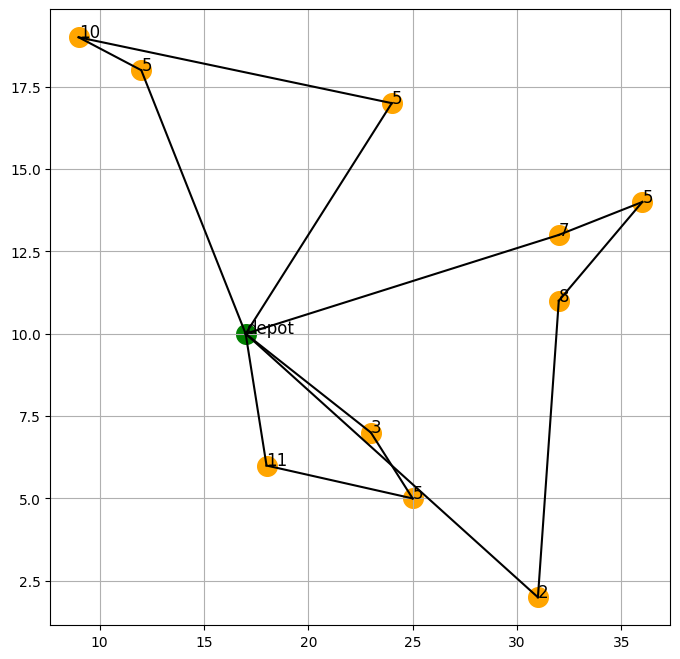

In [46]:
# visualization : plotting with matplolib
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i in nodos1:
    if i == 0:
        plt.scatter(c[i][0], c[i][1], c='green', s=200)
        plt.text(c[i][0], c[i][1], "depot", fontsize=12)
    else:
        plt.scatter(c[i][0], c[i][1], c='orange', s=200)
        plt.text(c[i][0], c[i][1], str(q[i]), fontsize=12)

for k in vehiculos:
    for i in nodos1:
        for j in nodos2:
            if i != j and X[i][j][k].value() == 1:
                plt.plot([c[i][0], c[j][0]], [c[i][1], c[j][1]], c="black")

plt.grid()
plt.show()

Para conocer las rutas, se hace lo siguiente,

In [43]:
variables = [(i, j, k) for i in nodos1 for j in nodos2 for k in vehiculos if X[i][j][k].varValue == 1]

# Inicializar las rutas
rutas = {}

# Procesar cada variable
for (i, j, k) in variables:
    if k not in rutas:
        rutas[k] = []
    rutas[k].append((i, j))

# Reconstruir las rutas
rutas_reconstruidas = {}
for k in rutas:
    ruta = []
    actual = 0  # Suponemos que todas las rutas comienzan desde el nodo 0
    while rutas[k]:
        for (i, j) in rutas[k]:
            if i == actual:
                ruta.append(j)
                actual = j
                rutas[k].remove((i, j))
                break
    rutas_reconstruidas[k] = ruta

# Imprimir las rutas
for k in rutas_reconstruidas:
    print(f"Ruta del vehículo {k}: 0 -> " + " -> ".join(map(str, rutas_reconstruidas[k])))


Ruta del vehículo 1: 0 -> 1 -> 7 -> 5 -> 0
Ruta del vehículo 2: 0 -> 2 -> 4 -> 3 -> 0
Ruta del vehículo 0: 0 -> 10 -> 9 -> 8 -> 6 -> 0


Y para graficarlas, se hace de la siguiente manera,

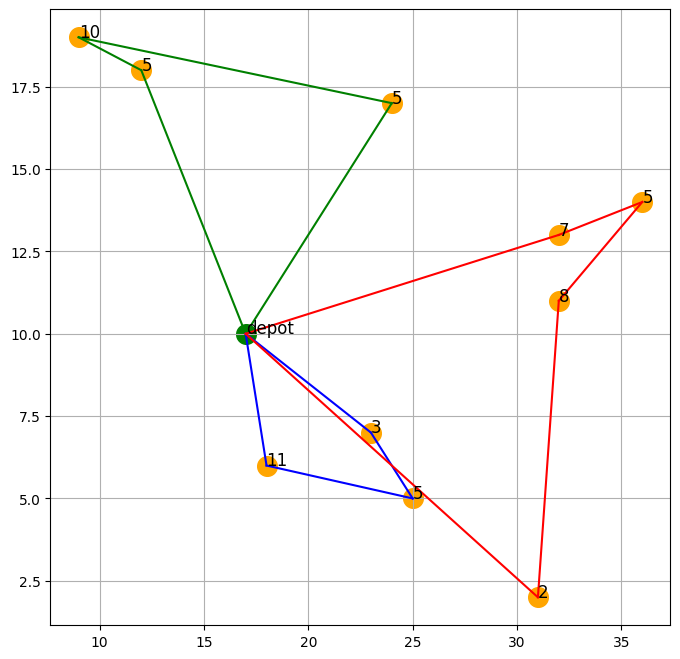

In [47]:
# Graficar las rutas
plt.figure(figsize=(8, 8))

# Dibujar los nodos
for i in nodos1:
    if i == 0:
        plt.scatter(c[i][0], c[i][1], c='green', s=200)
        plt.text(c[i][0], c[i][1], "depot", fontsize=12)
    else:
        plt.scatter(c[i][0], c[i][1], c='orange', s=200)
        plt.text(c[i][0], c[i][1], str(q[i]), fontsize=12)

# Dibujar las aristas para cada ruta
colors = ['r', 'g', 'b']
for k, ruta in rutas_reconstruidas.items():
    for i in range(len(ruta)):
        if i == 0:
            plt.plot([c[0][0], c[ruta[i]][0]], [c[0][1], c[ruta[i]][1]], c=colors[k])
        else:
            plt.plot([c[ruta[i-1]][0], c[ruta[i]][0]], [c[ruta[i-1]][1], c[ruta[i]][1]], c=colors[k])
    plt.plot([c[ruta[-1]][0], c[0][0]], [c[ruta[-1]][1], c[0][1]], c=colors[k])

plt.grid()
plt.show()